# Определение перспективного тарифа для телеком-компании

**Задача:**
<br /> Нужно проанализировать клиентов и сделать вывод - какой тариф приносит больше денег.

**Описание тарифов:**
* «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.*
<br />

* Тариф «Смарт»
<br />Ежемесячная плата: 550 рублей
<br />Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
<br />Стоимость услуг сверх тарифного пакета: 1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и <br />мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 2. сообщение: 3 рубля; 3. <br />1 Гб интернет-трафика: 200 рублей.
<br />
* Тариф «Ультра»
<br />Ежемесячная плата: 1950 рублей
<br />Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
<br />Стоимость услуг сверх тарифного пакета: 1. минута разговора: 1 рубль; 2. сообщение: 1 рубль; 3. 1 Гб интернет-трафика: 150 рублей.


**Описание данных:**

<br />Таблица `users` (информация о пользователях):
* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tarif — название тарифного плана

<br />Таблица `calls` (информация о звонках):
* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок

<br />Таблица `messages` (информация о сообщениях):
* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение

<br />Таблица `internet` (информация об интернет-сессиях):
* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя

<br />Таблица `tariffs` (информация о тарифах):
* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Общая информация о данных

Открываем файлы с данными и изучаем общую информацию.

In [1]:
#импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sb
import numpy as np
from scipy import stats as st
import copy

df_calls = pd.read_csv('/datasets/calls.csv')
df_internet = pd.read_csv('/datasets/internet.csv')
df_messages = pd.read_csv('/datasets/messages.csv')
df_tariffs = pd.read_csv('/datasets/tariffs.csv')
df_users = pd.read_csv('/datasets/users.csv')

In [2]:
#получим общую информацию сразу по всем дф
name_col = ['Информация о звонках', 'Информация об интернет-сессиях', 'Информация о сообщениях', 'Информация о тарифах', 'Информация о пользователях']
i = 0
for data in [df_calls, df_internet, df_messages, df_tariffs, df_users]:
    (print('=' * 20, name_col[i], '=' * 20))
    display(data.head(10))
    display(data.info())
    i = i + 1 
    

==================== Информация о звонках ====================


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

==================== Информация об интернет-сессиях ====================


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


None

==================== Информация о сообщениях ====================


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None

==================== Информация о тарифах ====================


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


None

==================== Информация о пользователях ====================


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None

**Таблица `df_calls` - информация о звонках**
* `call_date`- заменить тип данных на date
* `duration` - округлим вверх и поменяем тип данных

**Таблица `df_internet` - информация о интернет-сессиях:**
* `Unnamed: 0` - непонятный столбец, удалим его
* `mb_used` - округляем в большую сторону, меняем тип данных
* `session_date` - меняем тип данных на date

**Таблица `df_messages` - информация о сообщениях:**
* `message_date` - меняем тип данных на date

**Таблица `df_tariffs` - информация о тарифах:**
* все в порядке

**Таблица `df_users` - информация о пользователях:**
* `reg_date` - меняем тип данных на date
* `churn_date` - меняем тип данных на date


## Предобработка данных

### Подготовка данных ###

**Таблица df_calls - информация о звонках**

In [3]:
#Поменяем тип данных в call_date
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'])
#Округлим вверх значения минут, т.к «Мегалайн» всегда округляет вверх значения минут и мегабайтов и переведем в int
df_calls['duration'] = df_calls['duration'].apply(np.ceil).astype(int)
#Добавим столбец с месяцем, это нам понадобится в дальнейшем
df_calls['month'] = pd.DatetimeIndex(df_calls['call_date']).month
df_calls.info()
df_calls.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  int64         
 3   user_id    202607 non-null  int64         
 4   month      202607 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 7.7+ MB


,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12


**Таблица df_internet - информация о трафике**

In [4]:
# Поменяем тип данных в session_date
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'])
# Unnamed: 0 удалим столбец за ненадобностью
df_internet = df_internet.drop('Unnamed: 0', axis=1)
# mb_used округляем в большую сторону, т.к «Мегалайн» всегда округляет вверх значения минут и мегабайтов, меняем тип данных
df_internet['mb_used'] =  df_internet['mb_used'].apply(np.ceil).astype(int)
#Добавим столбец с месяцем, это нам понадобится в дальнейшем
df_internet['month'] = pd.DatetimeIndex(df_internet['session_date']).month
df_internet.info()
df_internet.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  int64         
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
 4   month         149396 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 5.7+ MB


,id,mb_used,session_date,user_id,month
0,1000_0,113,2018-11-25,1000,11
1,1000_1,1053,2018-09-07,1000,9
2,1000_2,1198,2018-06-25,1000,6
3,1000_3,551,2018-08-22,1000,8
4,1000_4,303,2018-09-24,1000,9


**Таблица df_messages - информация о сообщениях**

In [5]:
# Поменяем тип данных в message_date
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'])
# Добавим столбец с месяцем, это нам понадобится в дальнейшем
df_messages['month'] = pd.DatetimeIndex(df_messages['message_date']).month
df_messages.info()
df_messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
 3   month         123036 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 3.8+ MB


,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


**Таблица df_users - информация о пользователях**

In [6]:
#Поменяем тип даных в reg_date и churn_date
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'])
df_users['churn_date'] = pd.to_datetime(df_users['reg_date'])
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  500 non-null    datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


### Рассчет для каждого пользователя ###

#### Количество сделанных звонков и израсходованных минут разговора по месяцам;

In [7]:
calls = df_calls.groupby(['user_id', 'month'])['duration'].agg(['count', 'sum']).reset_index()
calls.columns = ['user_id','month','call','minute']
calls.head()

,user_id,month,call,minute
0,1000,5,22,159
1,1000,6,43,172
2,1000,7,47,340
3,1000,8,52,408
4,1000,9,58,466


#### Количество отправленных сообщений по месяцам

In [8]:
messages = df_messages.groupby(['user_id', 'month'])['id'].count().reset_index()
messages.columns = ['user_id', 'month', 'messages']
messages.head()

,user_id,month,messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


#### Объем израсходованного интернет-трафика по месяцам

In [9]:
traffic = df_internet.groupby(['user_id', 'month'])['mb_used'].sum().reset_index()
traffic.head()

,user_id,month,mb_used
0,1000,5,2256
1,1000,6,23257
2,1000,7,14016
3,1000,8,14070
4,1000,9,14581


#### Помесячная выручка с каждого пользователя

Соединим все таблицы в одну

In [10]:
cal_mes_traf = calls.merge(messages, how='outer', on=['user_id', 'month'])
cal_mes_traf = cal_mes_traf.merge(traffic, how='outer', on=['user_id', 'month'])
cal_mes_traf = cal_mes_traf.merge(df_users[['user_id','tariff']], how ='left', on = 'user_id')
cal_mes_traf.info()
cal_mes_traf



<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   3214 non-null   int64  
 1   month     3214 non-null   int64  
 2   call      3174 non-null   float64
 3   minute    3174 non-null   float64
 4   messages  2717 non-null   float64
 5   mb_used   3203 non-null   float64
 6   tariff    3214 non-null   object 
dtypes: float64(4), int64(2), object(1)
memory usage: 200.9+ KB


,user_id,month,call,minute,messages,mb_used,tariff
0,1000,5,22.0,159.0,22.0,2256.0,ultra
1,1000,6,43.0,172.0,60.0,23257.0,ultra
2,1000,7,47.0,340.0,75.0,14016.0,ultra
3,1000,8,52.0,408.0,81.0,14070.0,ultra
4,1000,9,58.0,466.0,57.0,14581.0,ultra
...,...,...,...,...,...,...,...
3209,1489,9,NaN,NaN,32.0,17232.0,smart
3210,1489,10,NaN,NaN,21.0,19588.0,smart
3211,1489,11,NaN,NaN,20.0,17516.0,smart
3212,1489,12,NaN,NaN,35.0,17341.0,smart


Посли формирования общей таблицы, по некоторым пользователям возникли пропуски, для дальнейшей работы заполним их нулями

In [11]:
cal_mes_traf.shape

(3214, 7)

In [12]:
cal_mes_traf.user_id.nunique()

498

In [13]:
nan_0 = ['call', 'minute', 'messages', 'mb_used']
for i in nan_0:
    cal_mes_traf[i] = cal_mes_traf[i].fillna(0).astype(int)
cal_mes_traf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   3214 non-null   int64 
 1   month     3214 non-null   int64 
 2   call      3214 non-null   int64 
 3   minute    3214 non-null   int64 
 4   messages  3214 non-null   int64 
 5   mb_used   3214 non-null   int64 
 6   tariff    3214 non-null   object
dtypes: int64(6), object(1)
memory usage: 200.9+ KB


Соберем функцию для подсчета выручки

In [14]:
def revenue(row):
    if row['tariff'] == 'ultra':
        inc_call = (row['minute'] - df_tariffs.loc[1, 'minutes_included']) * df_tariffs.loc[0, 'rub_per_minute']
        if inc_call < 0:
            inc_call = 0
            
        inc_msg = (row['messages'] - df_tariffs.loc[1, 'messages_included']) * df_tariffs.loc[0, 'rub_per_message']
        if inc_msg < 0:
            inc_msg = 0
            
        inc_mb = math.ceil((row['mb_used'] - df_tariffs.loc[1, 'mb_per_month_included'])/1024) * df_tariffs.loc[0, 'rub_per_gb']
        if inc_mb < 0:
            inc_mb = 0
            
        total = inc_call + inc_msg + inc_mb + df_tariffs.loc[1, 'rub_monthly_fee']
    else:
        row['tariff'] == 'smart'
        inc_call = (row['minute'] - df_tariffs.loc[0, 'minutes_included']) * df_tariffs.loc[0, 'rub_per_minute']
        if inc_call < 0:
            inc_call = 0
            
        inc_msg = (row['messages'] - df_tariffs.loc[0, 'messages_included']) * df_tariffs.loc[0, 'rub_per_message']
        if inc_msg < 0:
            inc_msg = 0
            
        inc_mb = math.ceil((row['mb_used'] - df_tariffs.loc[0, 'mb_per_month_included'])/1024) * df_tariffs.loc[0, 'rub_per_gb']
        if inc_mb < 0:
            inc_mb = 0
            
        total = inc_call + inc_msg + inc_mb + df_tariffs.loc[0, 'rub_monthly_fee']
    return total
cal_mes_traf['revenue'] = cal_mes_traf.apply(revenue, axis = 1)
cal_mes_traf.head(10)

,user_id,month,call,minute,messages,mb_used,tariff,revenue
0,1000,5,22,159,22,2256,ultra,1950
1,1000,6,43,172,60,23257,ultra,1950
2,1000,7,47,340,75,14016,ultra,1950
3,1000,8,52,408,81,14070,ultra,1950
4,1000,9,58,466,57,14581,ultra,1950
5,1000,10,57,350,73,14717,ultra,1950
6,1000,11,43,338,58,14768,ultra,1950
7,1000,12,46,333,70,9827,ultra,1950
8,1001,11,59,430,0,18452,smart,1350
9,1001,12,63,414,0,14053,smart,550


In [15]:
cal_mes_traf['revenue'].describe()

count    3214.000000
mean     1544.959863
std       829.030609
min       550.000000
25%       750.000000
50%      1667.500000
75%      1950.000000
max      6770.000000
Name: revenue, dtype: float64

## Анализ данных
 Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

### Расчет помесячного расхода минут разговора, сообщений и какой объём интернет-трафика для каждого тарифа

In [16]:
# Объединим требуемые данные в одну таблицу, упорядоченную по месяцам
cal_mes_traf_month = cal_mes_traf.groupby(['tariff', 'month'])['minute', 'messages', 'mb_used', 'revenue'].sum().reset_index()
cal_mes_traf_month.head(15)

/tmp/ipykernel_152/1217977329.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  cal_mes_traf_month = cal_mes_traf.groupby(['tariff', 'month'])['minute', 'messages', 'mb_used', 'revenue'].sum().reset_index()


,tariff,month,minute,messages,mb_used,revenue
0,smart,1,6931,620,289831,24525
1,smart,2,17324,1397,673461,48001
2,smart,3,30034,2453,1164537,89676
3,smart,4,41119,3443,1509702,107866
4,smart,5,54618,4762,2231353,169849
5,smart,6,64885,5478,2593622,198259
6,smart,7,82079,6784,3168466,247014
7,smart,8,99045,7905,3908561,312340
8,smart,9,111439,8746,4244377,326386
9,smart,10,125284,9927,4932898,402667


In [17]:
#Разобьем таблицу выше по тарифам
smart_cal_mes_traf_month = cal_mes_traf_month.query('tariff == "smart"')
ultra_cal_mes_traf_month = cal_mes_traf_month.query('tariff == "ultra"').reset_index()
#Тариф smart
smart_cal_mes_traf_month

,tariff,month,minute,messages,mb_used,revenue
0,smart,1,6931,620,289831,24525
1,smart,2,17324,1397,673461,48001
2,smart,3,30034,2453,1164537,89676
3,smart,4,41119,3443,1509702,107866
4,smart,5,54618,4762,2231353,169849
5,smart,6,64885,5478,2593622,198259
6,smart,7,82079,6784,3168466,247014
7,smart,8,99045,7905,3908561,312340
8,smart,9,111439,8746,4244377,326386
9,smart,10,125284,9927,4932898,402667


In [18]:
#Тариф ultra
ultra_cal_mes_traf_month

,index,tariff,month,minute,messages,mb_used,revenue
0,12,ultra,1,3853,304,118382,17550
1,13,ultra,2,7131,527,282887,47600
2,14,ultra,3,18117,1195,649423,75350
3,15,ultra,4,25191,1736,926409,111050
4,16,ultra,5,34192,2536,1298540,140650
5,17,ultra,6,40295,3505,1591148,174000
6,18,ultra,7,49667,4536,1866833,198250
7,19,ultra,8,54653,5183,2096565,227650
8,20,ultra,9,62036,6013,2210554,235650
9,21,ultra,10,68644,7187,2467856,259050


Данные за весь период по 2 тарифам, по всем показателям

In [19]:
tariff_use = cal_mes_traf_month.pivot_table(index = 'tariff', values=['minute', 'messages', 'mb_used', 'revenue'])
tariff_use

,mb_used,messages,minute,revenue
tariff,,,,
smart,3.014572e+06,6201.083333,77631.416667,240479.25
ultra,1.599550e+06,4051.916667,43227.000000,173312.50


Отсюда видно, что пользователи тарифа `smart`:
* Расходуют больше по всем показателям
* Вынуждены больше платить денег из-за нехватки базового пакета услуг
* Приносят больше денег компании
<br> **Посчитаем, сколько пользователей по 2 тарифам**

In [20]:
df_users.tariff.value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

Да, все так как и описано выше, только есть одно но:
* Клиентов тарифа smart больше чем в 2 раза

Построим гистограммы для наглядного сравнения двух тарифов по всем показателям

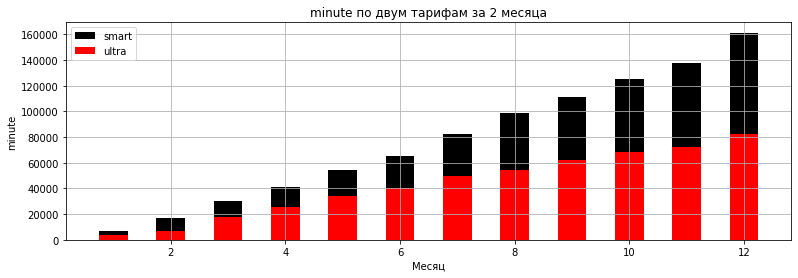

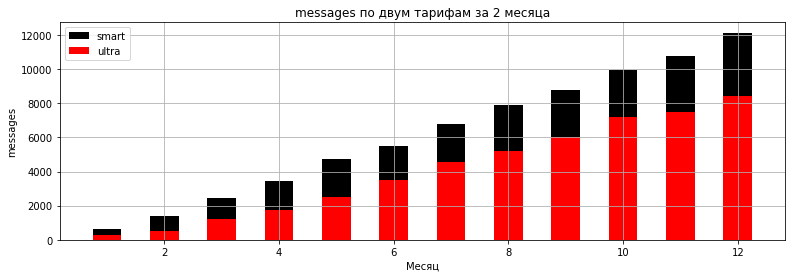

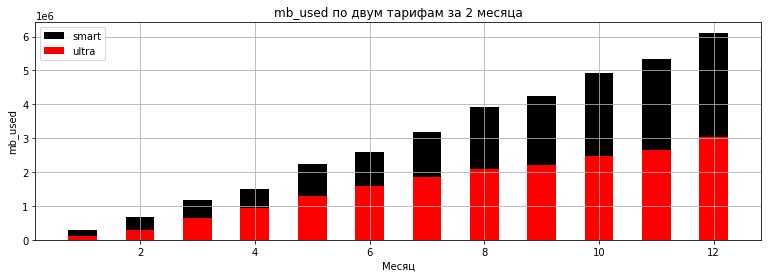

In [21]:
for i in ['minute', 'messages', 'mb_used']:
    plt.figure(figsize = (13,4))
    plt.bar(smart_cal_mes_traf_month['month'],
            smart_cal_mes_traf_month[i],
            label = 'smart',
            color = 'black', width = .5)
    plt.bar(ultra_cal_mes_traf_month['month'],
            ultra_cal_mes_traf_month[i],
            label = 'ultra',
            color = 'red', width = .5)
    plt.xlabel('Месяц')
    plt.ylabel(i)
    plt.grid()
    plt.title(i + ' по двум тарифам за 2 месяца')
    plt.legend()

Исходя из увиденного можно сделать вывод, что:
* Пользователи тарифа `smart` тратят больше на дополнительные пакеты услуг, им чаще не хватает того, что есть в тарифе, это вынуждает их докупать минуты, сообщения и мегабайты
* Пользователи тарифа `smart` приносят больше денег компании, кроме 2 и 4 месяца 
* Кол-во новых пользователей растет с каждым месяцем
* Пока трудно делать вывод о выгодности тарифа, ведь пользователей `smart` больше в 2 с лишним раза, нужно посчитать среднее на 1 пользователя

### Посчитаем среднее количество, дисперсию и стандартное отклонение. Построим гистограммы. Опишем распределения.

In [22]:
cal_mes_traf['gb_used'] = cal_mes_traf['mb_used'] / 1024
statistic = cal_mes_traf.pivot_table(index = 'tariff', values = ['minute', 'messages', 'gb_used', 'revenue'], 
                                    aggfunc = {'minute': [np.mean, np.var, np.std],
                                              'messages': [np.mean, np.var, np.std],
                                              'gb_used': [np.mean, np.var, np.std],
                                              'revenue': [np.mean, np.var, np.std, np.median]})
statistic

gb_used                        messages                          \
             mean       std        var       mean        std          var   
tariff                                                                      
smart   15.848817  5.739821  32.945548  33.384029  28.227876   796.812958   
ultra   19.030177  9.859685  97.213384  49.363452  47.804457  2285.266143   

            minute                                revenue                      \
              mean         std            var        mean  median         std   
tariff                                                                          
smart   417.934948  190.313730   36219.315784  1294.63930  1038.0  820.933202   
ultra   526.623350  317.606098  100873.633397  2111.42132  1950.0  505.069836   

                       
                  var  
tariff                 
smart   673931.321363  
ultra   255095.538773

In [23]:
statistic.T

tariff                   smart          ultra
gb_used  mean        15.848817      19.030177
         std          5.739821       9.859685
         var         32.945548      97.213384
messages mean        33.384029      49.363452
         std         28.227876      47.804457
         var        796.812958    2285.266143
minute   mean       417.934948     526.623350
         std        190.313730     317.606098
         var      36219.315784  100873.633397
revenue  mean      1294.639300    2111.421320
         median    1038.000000    1950.000000
         std        820.933202     505.069836
         var     673931.321363  255095.538773

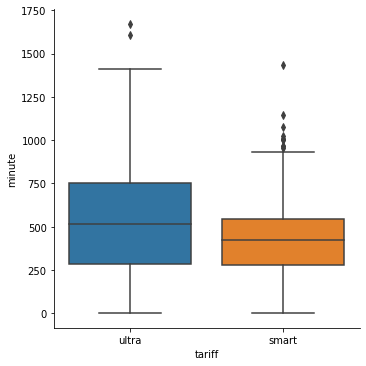

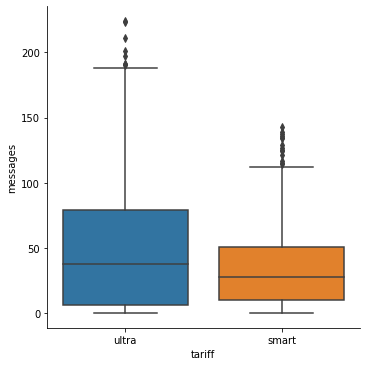

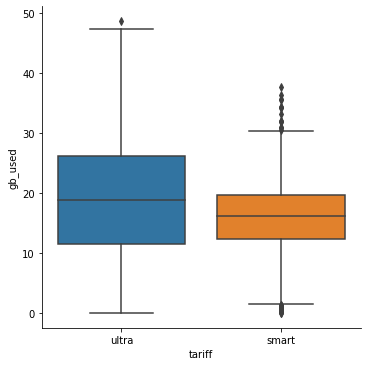

In [24]:
#Построим гистаграммы
for column in ['minute', 'messages', 'gb_used']:    
    sb.catplot(x='tariff', y=column, kind="box", data=cal_mes_traf)  

**По диаграмме размаха можно сделать след выводы:**
* Межквартильный размах больше у тарифа `ultra` больше смарта, это говорит о неоднородности среди пользователей
* Судя по бОльшей медиане у `ultra`, можно сделать вывод, что пользователи этого тарифа в целом тратят больше ресурсов чем пользователи тарифа `smart`.
* Пользователи тарифа `ultra` зачастую не используют весь потенциал своего тарифа
* Межквартильный размах у `smart` говорит о том, что пользователи этого тарифа зачастую строго укладываются в рамки тарифа и стараются не превышать, единственное то, что они грешат с использованием интернета и 15 гб им совсем не хватает, отсюда понятно, что они вынуждены тратить больше на доп.услуги


Построим гистограммы

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Время разговоров по двум тарифам')

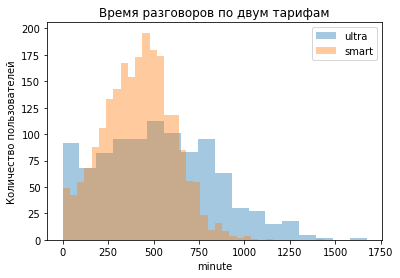

In [25]:
for t in ['ultra', 'smart']:
        sb.distplot(cal_mes_traf.query('tariff == @t')['minute'], kde=False)
plt.legend(['ultra', 'smart'])
plt.ylabel('Количество пользователей')
plt.title('Время разговоров по двум тарифам')


* Тут наблюдаем, что пользователи тарифа `smart` разговаривают в рамках своего тарифа, но иногда докупают дополнительные минуты, но не очень много.
* Пользователи же тарифа `ultra` расходуют минуты равномерно, это связано с большим запасом минут в рамках тарифа, поэтому не следят за тратой минут, но у этого тарифа слишком большой запас, пользователи не расходуют все минуты.

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Сообщения по двум тарифам')

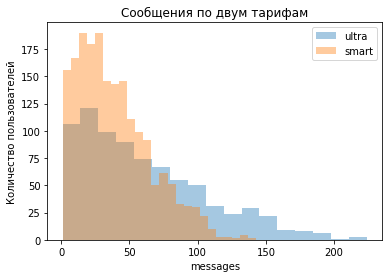

In [26]:
#Лишим нулей кол-во сообщений, чтобы отсечь тех людей, которым в принципе они не нужны
cal_mes_traf_0 = cal_mes_traf.query('messages > 0')
for t in ['ultra', 'smart']:
        sb.distplot(cal_mes_traf_0.query('tariff == @t')['messages'], kde=False)
plt.legend(['ultra', 'smart'])
plt.ylabel('Количество пользователей')
plt.title('Сообщения по двум тарифам')

* Наблюдаем положительное распределение, но у пользователей `ultra` оно однороднее, а вот у пользователей `smart` подовляющее большинство останавливается на 50 сообщениях, по условиям тарифа, чтобы не переплачивать.
* Но и пользователям тарифа `ultra` особо не пользуются сообщениями и не используют весь потенциал своего тарифа

Text(0.5, 1.0, 'Трафик по двум тарифам')

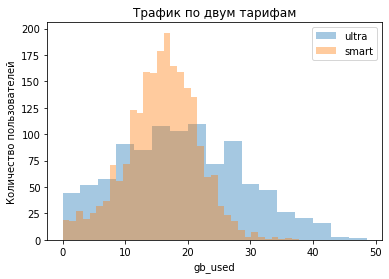

In [27]:
for t in ['ultra', 'smart']:
        sb.distplot(cal_mes_traf.query('tariff == @t')['gb_used'], kde=False)
plt.legend(['ultra', 'smart'])
plt.ylabel('Количество пользователей')
plt.title('Трафик по двум тарифам')

* Здесь нормальное распределение, половина пользователей тарифа `smart` пытаются укладываться в рамки тарифа, половина постоянно докупают трафик, в основном пользователи перерасходуют трафик.
* Пользователи тарифа `ultra` также особо не следят за трафиком и тратят сколько им потребуется, но все-таки бывает выходят за рамки тарифа

<div class="alert alert-success">
<b>Комментарий ревьюера:</b>

Обрати внимание, что наши действия повторяются с точки зрения построения графиков.
    
Это говорит о том, что мы можем создать функцию, которая будет выполнять все действия за нас.
    
Тем самым мы сможем оптимизировать свой код и проект целиком.
    
</div>

**Вывод**

Судя по графика, можно сказать, что:
* Пользователи тарифа `ultra` могут вести себя более разнообразно, они ничем не ограничены и почти всегда не выбирают весь доступный им пакет услуг, кроме трафика, его они иногда докупают
* Пользователи тарифа `smart` чаще всего ограничены своим тарифным планом и стараются не перебирать с услугами, если дело не касается трафика, тут они чаще всего платят за перерасход
* В среднем пользователи тарифа `ultra` расходуют больше по всем показателям, но почти никогда не расходуют до конца свой тариф
* Пользователи тарифа `ultra` приносят больше денег компании, но тариф `smart` популярнее

## Проверка гипотез

### Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Проверка гипотез начинается с формулировки нулевой гипотезы H0:
* H0  — средняя выручка пользователей тарифа «Ультра» равна средней выручке пользователей тарифа «Смарт».

Отвергнув/подтвердив ее мы ответим на требуемый вопрос

Исходя из H0 формулируется альтернативная гипотеза H1. Это утверждение, которое принимается верным, если отбрасывается H0:
* H1 — средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

Имеем две генральные совокупности доход по тарифам `ultra` и `smart`, поэтому будем сравнивать средние двух генеральных совокупностей между собой методом scipy.stats.ttest_ind()

Пороговое значение:
* alpha = 1%

In [28]:
ultra = cal_mes_traf.query('tariff == "ultra"')['revenue']
ultra

0       1950
1       1950
2       1950
3       1950
4       1950
        ... 
3204    1950
3205    1950
3206    1950
3207    1950
3213    1950
Name: revenue, Length: 985, dtype: int64

In [29]:
ultra = cal_mes_traf.query('tariff == "ultra"')['revenue']
smart = cal_mes_traf.query('tariff == "smart"')['revenue']

alpha = .01

results = st.ttest_ind(
    ultra, 
    smart, 
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.0624304050009335e-218
Отвергаем нулевую гипотезу


In [30]:
#Средняя выручка
cal_mes_traf.pivot_table(index = 'tariff', values = 'revenue', aggfunc = 'median')

,revenue
tariff,
smart,1038
ultra,1950


Доход с пользователя тарифа `ultra` больше почти в 2 раза

С уверенностью 99% можно подтвердить, что выручка средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

### Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Проверять будем по аналогии с предыдущей гипотезой

H0 — средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов.

H1 — средняя выручка пользователей из Москвы отличается от средней выручке пользователей из других регионов.

alpha = 1%

In [31]:
# Добавим столбец с городом в таблицу
cal_mes_traf = cal_mes_traf.merge(df_users[['user_id','city']], how ='left', on = 'user_id')
moscow = cal_mes_traf.query('city == "Москва"')['revenue']
regions = cal_mes_traf.query('city != "Москва"')['revenue']

alpha = .01

results = st.ttest_ind(
    moscow, 
    regions, 
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.4643370041266579
Не получилось отвергнуть нулевую гипотезу


In [32]:
def reg_city(city):
    if city == 'Москва':
        return 'Москва'
    else:
        return 'Регион'

cal_mes_traf['region'] = cal_mes_traf['city'].apply(reg_city)
cal_mes_traf.pivot_table(index = 'region', values = 'revenue', aggfunc = 'median')

,revenue
region,
Москва,1750
Регион,1587


Данный статистический тест не опроверг нулевую гипотезу, это означает, что разницы между средней выручки Москвы и остальных городов нет.
Дествительно выручка Москвы не сильно отличается от регионов

**Вывод**

Были выдвинуты две гипотезы:

Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.
Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Гипотеза 1 подтвердилась и говорит нам о том, что выручка по тарифамм отличается. По средней выручке можно предположить, что выручка по тарифу `ultra` почти в 2 раза больше, чем у `smart`.

Гипотеза 2 была опровергнута. Это значит, что нормальное распределение по выручке за месяц между городом Москва и остальной страной не отличается.



## Вывод

В ходе проделанной работы было выполнено:

* Просмотрена каждая таблица и выявлены ошибки в данных
* Подготовлены данные для последующей работы
* Составлена общая таблица данных о пользователях сети
* Проведен сравнительный анализ пользователей тарифов
* Проверены гипотезы
* Предложенные тарифы сильно отличаются друг от друга и их выручка разнится. В первую очередь пользователи тарифа `smart` чаще пользователей тарифа `ultra` перерасходуют лимиты. Из-за это выручка по тарифу Smart может казаться большой, но и пользователей этого тарифа больше почти в 2 раза

Особенности использования тарифов заключаются в следующем:

* Пользователям тарифа `smart` не хватает услуг в рамках тарифного пакета, перерасход чаще всего связан с трафиком.
* Пользователи тарифа `ultra`, наоборот не полностью расходуют данный им пакет
* Средние доходы от пользователей в Москве не отличаются от доходов в других населенных пунктах: разница статистически незначима (p-значение: 0,464) и составляет 163 руб.: 1750 руб. в Москве против 1587 руб в других населенных пунктах.

Вывод из проделаной работы такой:
* С точки зрения бизнеса, тариф `ultra` является выгодным, но с точки зрения пользователя им не к чему такие лимиты, они переплачивают за то, чем не пользуются.
* Тариф `smart` не так хорошо с точки зрения бизнеса, но хорош с точки зрения пользователя, хоть они и норовят превысить лимиты.

Эти два тарифа выглядят как 2 крайности, следует добавить что-то посередине, с увеличенными лимитами и абонентской платой
